# Hierarchical Clustering application : Breast Cancer 

We will use real gene expression data in breast cancer (RNA-seq human genome sequencing data) from the public TCGA-BRCA database: https://portal.gdc.cancer.gov/. The data has been preprocessed, including alignment, normalization using the FPKM method, and log-transformed $log_2$(1+FPKM). It is ready for analysis

## 1. EDA

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_csv('breast_cancer.csv', sep=';', index_col='id_sample')
print('data', data.shape)

data (1016, 51)


In [3]:
data.head()

,NAT1,BIRC5,BAG1,BCL2,BLVRA,CCNB1,CCNE1,CDC6,CDC20,CDH3,...,GPR160,UBE2T,CXXC5,ANLN,CEP55,ACTR3B,MLPH,NUF2,TMEM45B,pam50
id_sample,,,,,,,,,,,,,,,,,,,,,
TCGA-3C-AAAU-01A,7.100449,3.361004,3.972581,4.145669,4.765233,4.788987,2.164814,2.633598,4.131205,0.133455,...,4.150233,4.106918,5.528618,3.073409,2.669860,1.928460,5.567999,2.536764,0.213597,luminal-A
TCGA-3C-AALI-01A,3.453640,4.501040,2.720929,1.493020,5.823480,5.281003,2.535437,2.734157,4.176553,0.110023,...,5.561226,5.648057,4.711309,3.881110,3.357553,1.168684,7.064176,3.124620,3.946538,HER2-enriched
TCGA-3C-AALJ-01A,4.455574,4.164643,3.911511,4.191457,5.987255,5.229446,2.267963,3.379961,4.592752,0.236786,...,2.859309,5.213461,6.152875,2.697093,2.599436,1.177678,5.222420,3.053335,0.281303,luminal-B
TCGA-3C-AALK-01A,4.297961,3.920234,3.688335,3.894904,5.211594,4.014641,0.951107,1.472950,3.806552,0.062392,...,3.063807,4.166154,5.612184,2.645664,2.448027,1.026535,6.225590,1.717959,3.289543,luminal-A
TCGA-4H-AAAK-01A,1.695378,2.950846,4.110014,3.572843,4.317856,3.772768,1.103958,2.338953,3.473484,0.098773,...,3.289418,3.437585,4.299617,2.068516,2.152652,1.513181,5.485277,1.537125,2.976903,luminal-A


Le dataframe contient les niveaux d’expression de 50 gènes (NAT1, BIRC5, BAG1, etc.) dans différents échantillons (effectif total n=1016). La dernière colonne nommée **pam50** contient le sous-type moléculaire du cancer du sein, mesuré pour chaque échantillon. Quatre sous-types moléculaires sont disponibles : **luminal-A**, **luminal-B**, **HER2-enriched** et **basal-like**. 

In [4]:
data.groupby(['pam50']).size()

pam50
HER2-enriched     82
basal-like       190
luminal-A        543
luminal-B        201
dtype: int64

In [5]:
#split data
X = data.select_dtypes('number') 
y = data['pam50']
print('X', X.shape,'y', y.shape)

X (1016, 50) y (1016,)


<AxesSubplot:ylabel='Expression'>

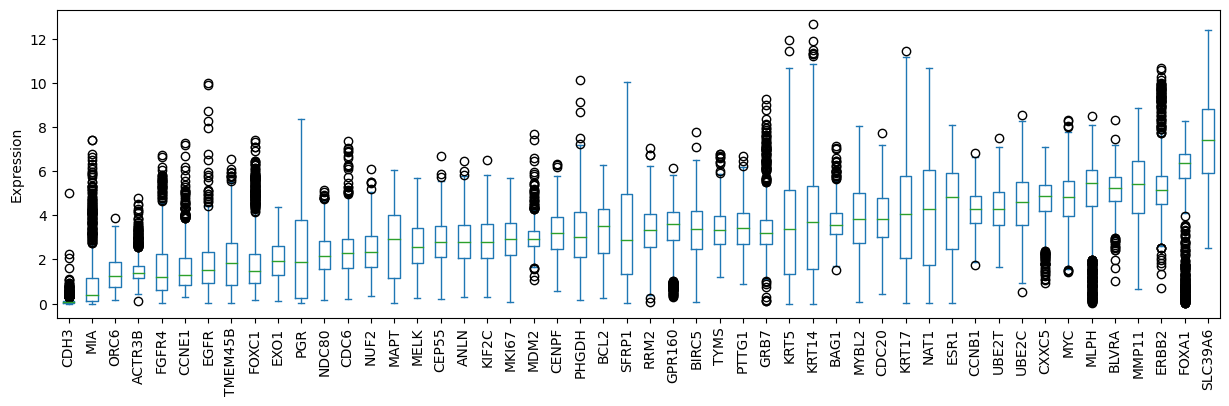

In [6]:
sort_by_mean = X.mean().sort_values(ascending=True)
X[sort_by_mean.index].plot(kind='box', figsize=(15, 4), rot=90, ylabel='Expression')

For some genes, expression levels vary significantly, while for others, they do not. The ranges of values differ from one gene to another. Genes with high absolute variance will carry more weight in the analysis than those with low variance. For this reason, ***the data must be normalized (standardized) without exception***.

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() 
X_scaled = scaler.fit_transform(X) # normalization
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns) # conversion of results into pd dataframe


<AxesSubplot:ylabel='Expression'>

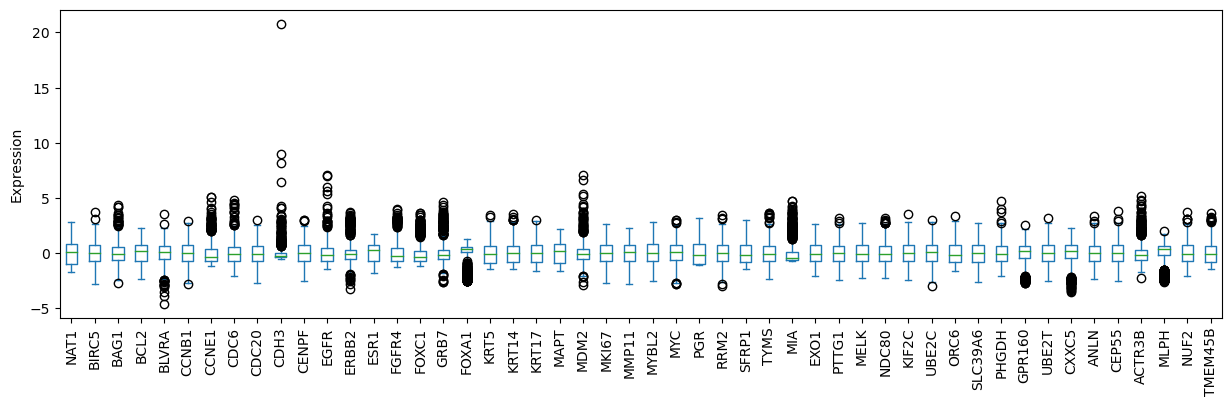

In [8]:
X_scaled.plot(kind='box', figsize=(15, 4), rot=90, ylabel='Expression')

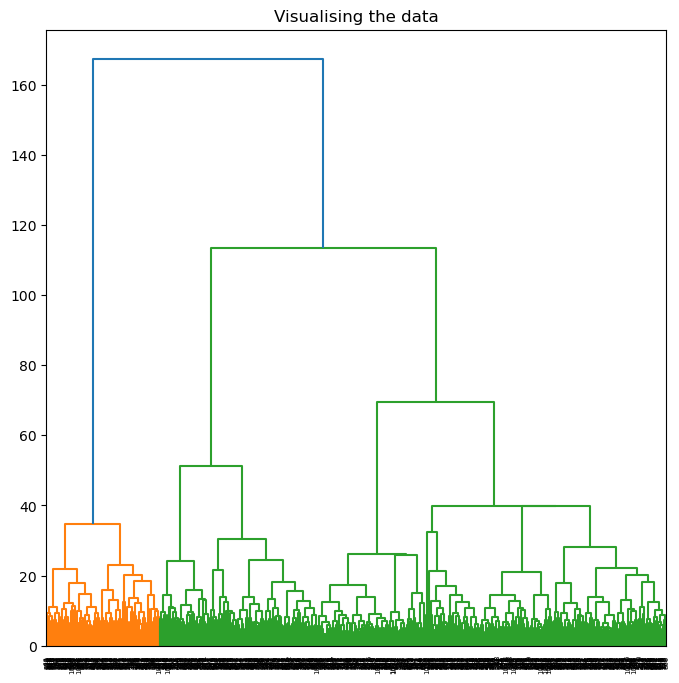

In [9]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize =(8, 8))
plt.title('Visualising the data')
Dendrogram = shc.dendrogram((shc.linkage(X_scaled, method ='ward')))

## 2. Modeling

In [10]:
#split the data
np.random.seed(42)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled,  y,  test_size = 0.3)

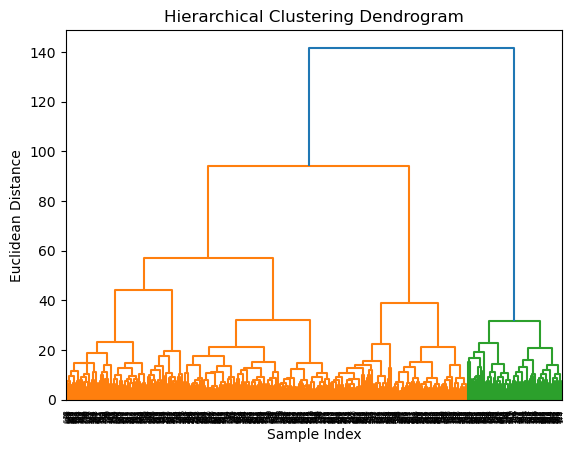

In [11]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

agg_clustering = AgglomerativeClustering(n_clusters=4)

train_clusters_agg = agg_clustering.fit_predict(X_train)

linked = linkage(X_train, 'ward')  
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Euclidean Distance')
plt.show()

Some common evaluation metrics include the silhouette score, the Davies-Bouldin index, and visual inspection of clusters.

For silhouette_score:

A score around 0.2 is considered acceptable, suggesting a reasonable separation between clusters.

Scores closer to 1 indicate well-defined clusters, while scores closer to 0 indicate overlapping clusters.

In [12]:
from sklearn.metrics import silhouette_score


silhouette_train = silhouette_score(X_train, y_train)
print(f"Silhouette Score (Training): {silhouette_train}")


silhouette_test = silhouette_score(X_test, y_test)
print(f"Silhouette Score (Testing): {silhouette_test}")

Silhouette Score (Training): 0.19294770190940944
Silhouette Score (Testing): 0.16547155105424496


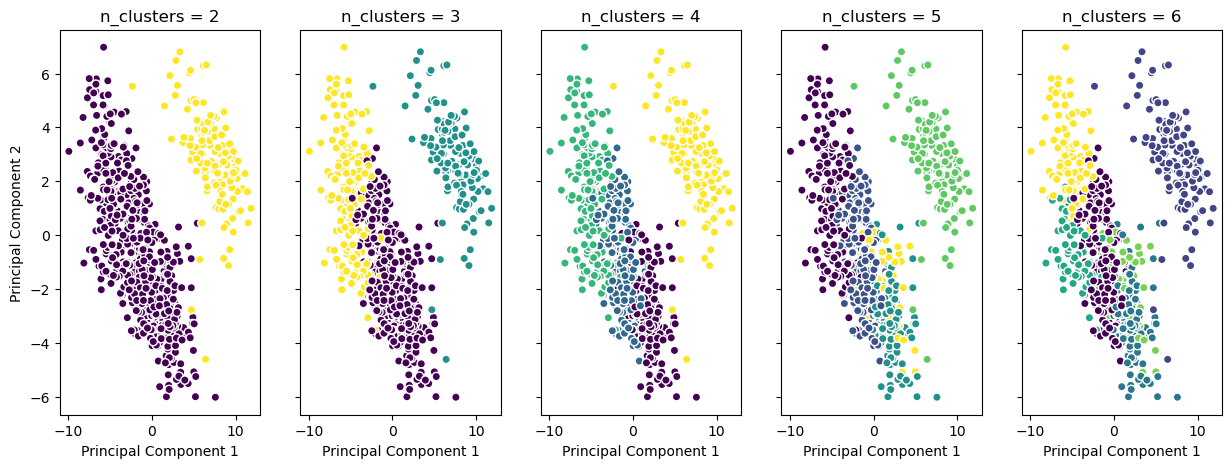

In [13]:
from sklearn.decomposition import PCA

n_clusters_range = range(2, 7)
silhouette_train_scores = []
silhouette_test_scores = []

fig, axes = plt.subplots(1, len(n_clusters_range), figsize=(15, 5), sharey=True)

for i, n_clusters in enumerate(n_clusters_range):
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
    
    train_clusters_agg = agg_clustering.fit_predict(X_train)
    silhouette_train = silhouette_score(X_train, train_clusters_agg)
    silhouette_train_scores.append(silhouette_train)
    
    test_clusters_agg = agg_clustering.fit_predict(X_test)
    
    silhouette_test = silhouette_score(X_test, test_clusters_agg)
    silhouette_test_scores.append(silhouette_test)
    
    pca = PCA(n_components=2)
    X_train_pca = pca.fit_transform(X_train)
    
    axes[i].scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=train_clusters_agg, cmap='viridis', edgecolors='w')
    axes[i].set_title(f'n_clusters = {n_clusters}')
    axes[i].set_xlabel('Principal Component 1')
    
axes[0].set_ylabel('Principal Component 2')

plt.show()

In [14]:
print("silhouette_train_scores :",silhouette_train_scores)
print("silhouette_test_scores :",silhouette_test_scores)

silhouette_train_scores : [0.3438057324067215, 0.1936161180231543, 0.13364441122539827, 0.13618130522020608, 0.1278657051834046]
silhouette_test_scores : [0.32608819020233915, 0.2013201422829397, 0.2040224240170743, 0.15912109032609006, 0.11838715924128618]
